In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import concatenate, Input, Dense, GlobalAveragePooling2D, Conv2D
# import tensorflow_addons as tfa
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate, GlobalAveragePooling2D
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Concatenate

train_csv_path = '/content/drive/MyDrive/small_data_2900/train.csv'
# test_csv_path = '/content/drive/MyDrive/images_folder_benign_mal_small/test.csv'

benign_dir = '/content/drive/MyDrive/small_data_2900/benign'
malignant_dir = '/content/drive/MyDrive/small_data_2900/malignant'

train_df = pd.read_csv(train_csv_path)
# test_df = pd.read_csv(test_csv_path)

# Clean and preprocess data
metadata = train_df.drop(columns=['benign_malignant', 'image_name', 'patient_id', 'lesion_id'])
mean_age = metadata['age_approx'].mean()
metadata['age_approx'] = metadata['age_approx'].fillna(mean_age)
metadata['anatom_site_general_challenge'] = metadata['anatom_site_general_challenge'].fillna('Unknown')

scaler = MinMaxScaler()
metadata['age_approx'] = scaler.fit_transform(metadata[['age_approx']])
mode_sex = metadata['sex'].mode()[0]
metadata['sex'] = metadata['sex'].fillna(mode_sex)

anatom_site_encoder = LabelEncoder()
metadata['anatom_site_general_challenge'] = anatom_site_encoder.fit_transform(metadata['anatom_site_general_challenge'])

sex_encoder = LabelEncoder()
metadata['sex'] = sex_encoder.fit_transform(metadata['sex'])

diagnosis_encoder = LabelEncoder()
metadata['diagnosis'] = diagnosis_encoder.fit_transform(metadata['diagnosis'])
diagnosis_one_hot = pd.get_dummies(metadata['diagnosis'], prefix='diagnosis')
metadata = pd.concat([metadata, diagnosis_one_hot], axis=1)
metadata = metadata.drop(columns=['diagnosis'])  # Drop original column if no longer needed

# Preprocess images
def preprocess_image(filepath):
    img = tf.keras.preprocessing.image.load_img(filepath, target_size=(128, 128))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = tf.keras.applications.resnet50.preprocess_input(img)
    return img

# Create a dictionary to store images and their labels
image_dict = {}
for dir_path, label in [(benign_dir, 0), (malignant_dir, 1)]:
    for fname in os.listdir(dir_path):
        filepath = os.path.join(dir_path, fname)
        if os.path.exists(filepath):
            image_dict[fname] = (preprocess_image(filepath), label)

# Filter the dataframe to include only entries with corresponding images
train_df = train_df[train_df['image_name'].apply(lambda x: x + '.jpeg' in image_dict)]
train_df = train_df.sort_values(by='image_name')

# Extract images and labels
images = []
labels = []
for img_name in train_df['image_name']:
    img, label = image_dict[img_name + '.jpeg']
    images.append(img)
    labels.append(label)
images = np.array(images)
labels = np.array(labels)
train_df = train_df.drop(columns=['image_name'])
metadata_filtered = metadata[metadata.index.isin(train_df.index)].reset_index(drop=True)
# Split data into training and validation sets
X_train_img, X_val_img, X_train_meta, X_val_meta, y_train, y_val = train_test_split(
    images, metadata_filtered, labels, test_size=0.3, random_state=42)

# Define MirroredStrategy for multi-GPU training
mirrored_strategy = tf.distribute.MirroredStrategy()

# Data augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.2),
    tf.keras.layers.RandomTranslation(0.1, 0.1),
])

# 1. Define ResNet50 Model
def create_resnet_model():
    with mirrored_strategy.scope():
        image_input = Input(shape=(128, 128, 3))
        augmented_images = data_augmentation(image_input)
        base_model = tf.keras.applications.ResNet50(include_top=False, input_tensor=augmented_images, weights='imagenet')
        for layer in base_model.layers:
            layer.trainable = True
        x = base_model.output
        x = GlobalAveragePooling2D()(x)

        metadata_input = Input(shape=(X_train_meta.shape[1],))
        y = Dense(128, activation='relu')(metadata_input)
        y = Dense(64, activation='relu')(y)
        y = Dense(32, activation='relu')(y)
        y = Dense(16, activation='relu')(y)

        concatenated = Concatenate()([x, y])
        output = Dense(1, activation='sigmoid')(concatenated)

        model = Model(inputs=[image_input, metadata_input], outputs=output)
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
        model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    return model

# 2. Define EfficientNet Model
def create_efficientnet_model():
    with mirrored_strategy.scope():
        image_input = Input(shape=(128, 128, 3))
        augmented_images = data_augmentation(image_input)
        base_model = tf.keras.applications.EfficientNetB0(include_top=False, input_tensor=augmented_images, weights='imagenet')
        for layer in base_model.layers:
            layer.trainable = True
        x = base_model.output
        x = GlobalAveragePooling2D()(x)

        metadata_input = Input(shape=(X_train_meta.shape[1],))
        y = Dense(128, activation='relu')(metadata_input)
        y = Dense(64, activation='relu')(y)
        y = Dense(32, activation='relu')(y)
        y = Dense(16, activation='relu')(y)

        concatenated = Concatenate()([x, y])
        output = Dense(1, activation='sigmoid')(concatenated)

        model = Model(inputs=[image_input, metadata_input], outputs=output)
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
        model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    return model


resnet_model = create_resnet_model()
efficientnet_model = create_efficientnet_model()

resnet_preds = resnet_model.predict([X_val_img, X_val_meta])
efficientnet_preds = efficientnet_model.predict([X_val_img, X_val_meta])
# 3. Define SE-ResNeXt Model
# Fix: Use EfficientNetV2 or another model from tf.keras.applications

pseudo_labels = (resnet_preds.flatten() + efficientnet_preds.flatten()) / 2
# Convert to binary pseudo-labels (0 or 1) with a threshold
pseudo_labels = (pseudo_labels > 0.5).astype(int)

# 3. Train the EfficientNetV2 model on both real labels and pseudo-labels
# Combine original labels and pseudo-labels in a new training set
combined_labels = np.concatenate([y_train, pseudo_labels])
combined_images = np.concatenate([X_train_img, X_val_img])
combined_metadata = np.concatenate([X_train_meta, X_val_meta])


combined_images = combined_images.astype('float32')
combined_metadata = combined_metadata.astype('float32')
combined_labels = combined_labels.astype('int')

combined_images = np.nan_to_num(combined_images)
combined_metadata = np.nan_to_num(combined_metadata)

# Now you can proceed with the rest of the script
def create_efficientnetv2_model():
    image_input = Input(shape=(128, 128, 3))
    augmented_images = data_augmentation(image_input)
    base_model = tf.keras.applications.EfficientNetV2B0(include_top=False, input_tensor=augmented_images, weights='imagenet')
    for layer in base_model.layers:
        layer.trainable = True
    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    metadata_input = Input(shape=(X_train_meta.shape[1],))
    y = Dense(128, activation='relu')(metadata_input)
    y = Dense(64, activation='relu')(y)
    y = Dense(32, activation='relu')(y)
    y = Dense(16, activation='relu')(y)

    concatenated = Concatenate()([x, y])
    output = Dense(1, activation='sigmoid')(concatenated)

    model = Model(inputs=[image_input, metadata_input], outputs=output)
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    return model
efficientnetv2_model = create_efficientnetv2_model()

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5, min_lr=1e-6)
checkpoint_resnet = tf.keras.callbacks.ModelCheckpoint('best_resnet_model.keras', monitor='val_loss', save_best_only=True, mode='min')
checkpoint_efficientnet = tf.keras.callbacks.ModelCheckpoint('best_efficientnet_model.keras', monitor='val_loss', save_best_only=True, mode='min')
checkpoint_efficientnetv2 = tf.keras.callbacks.ModelCheckpoint(
    'best_efficientnetv2_model.keras', monitor='val_accuracy',
    save_best_only=True, mode='max', verbose=1
)

print("training resnet teacher model ")
# Train ResNet50 model
history_resnet = resnet_model.fit(
    [X_train_img, X_train_meta], y_train,
    epochs=60, batch_size=128,
    validation_data=([X_val_img, X_val_meta], y_val),
    callbacks=[early_stopping, lr_scheduler, checkpoint_resnet]
)

print("training efficientnet big (teacher) model")
history_efficientnet = efficientnet_model.fit(
    [X_train_img, X_train_meta], y_train,  # Corrected variable names
    epochs=60, batch_size=128,
    validation_data=([X_val_img, X_val_meta], y_val),
    callbacks=[early_stopping, lr_scheduler, checkpoint_efficientnet]
)

print("training efficientnetv2  student model")
history_efficientnetv2 = efficientnetv2_model.fit(
    [combined_images, combined_metadata], combined_labels,
    epochs=60, batch_size=128,
    validation_data=([X_val_img, X_val_meta], y_val),
    callbacks=[early_stopping, lr_scheduler, checkpoint_efficientnetv2]
)

best_val_accuracy = max(history_efficientnetv2.history['val_accuracy'])
print(f'Best Validation Accuracy during training: {best_val_accuracy:.4f}')

# Load the best weights and make predictions
efficientnetv2_model.load_weights('best_efficientnetv2_model.keras')

# Define Ensemble Method
efficientnetv2_preds = efficientnetv2_model.predict([X_val_img, X_val_meta])
efficientnetv2_binary_preds = (efficientnetv2_preds.flatten() > 0.5).astype(int)

# Calculate accuracy on the validation set for comparison
efficientnetv2_accuracy = accuracy_score(y_val, efficientnetv2_binary_preds)
print(f'EfficientNetV2 Model Accuracy (Knowledge Transfer): {efficientnetv2_accuracy:.4f}')

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 120ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 174ms/step
24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
training resnet teacher model 
Epoch 1/60
16/16 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.6577 - loss: 0.6430 - val_accuracy: 0.8082 - val_loss: 1.2170 - learning_rate: 1.0000e-04
Epoch 2/60
16/16 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.8181 - loss: 0.3785 - val_accuracy: 0.8082 - val_loss: 0.9950 - learning_rate: 1.0000e-04
Epoch 3/60
16/16 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.8584 - loss: 0.3096 - val_accuracy: 0.8116 - val_loss: 0.9546 - learning_rate: 1.0000e-04
Epoch 4/60
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 724ms/step - accuracy: 0.8743 - loss: 0.2853 - val_accuracy: 0.8139 - val_loss: 1.0651 - learning_rate: 1.0000e-04
Epoch 5/60
16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 880ms/step - accuracy: 0.8948 - loss: 0.2471 - val_accuracy: 0.8071 - val

In [7]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np

# Load the saved EfficientNetV2 model
model = load_model('/content/best_efficientnetv2_model.keras') # Replace with the actual path

def preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(128, 128))
    img_array = image.img_to_array(img)
    img_array = tf.keras.applications.resnet50.preprocess_input(img_array)  # Assuming the same preprocessing as training
    img_array = np.expand_dims(img_array, axis=0)
    return img_array


def predict_image(image_path, metadata): # metadata is needed for the input
    img = preprocess_image(image_path)

    # Make the prediction
    prediction = model.predict([img, metadata]) #provide the metadata input here as well

    return prediction

# Example usage:  Replace with the path of your image file and metadata.
# for benign images testing
image_path1 = '/content/drive/MyDrive/small_data_2900/benign/ISIC_0015719.jpeg' # Example path. Change this.
# for malignant image testing
image_path2 = '/content/drive/MyDrive/small_data_2900/malignant/ISIC_0247330.jpeg' # Example path. Change this.


# for benign images testing
# create dummy metadata
metadata1 = np.zeros((1, X_train_meta.shape[1])) # dummy metadata
metadata2 = np.zeros((1, X_train_meta.shape[1])) # dummy metadata

# for benign images testing
prediction1 = predict_image(image_path1, metadata)
prediction2 = predict_image(image_path2, metadata)

# the testing for bening image
print("the testing for bening image")
if prediction1[0][0] > 0.5:
    print(f"The image is predicted as Malignant with probability {prediction1[0][0]:.4f}")
else:
    print(f"The image is predicted as Benign with probability {1 - prediction1[0][0]:.4f}")
# the testing for malignant image
print("the testing for malignant image")
if prediction2[0][0] > 0.5:
    print(f"The image is predicted as Malignant with probability {prediction2[0][0]:.4f}")
else:
    print(f"The image is predicted as Benign with probability {1 - prediction2[0][0]:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
the testing for bening image
The image is predicted as Benign with probability 0.5736
the testing for malignant image
The image is predicted as Malignant with probability 0.6132


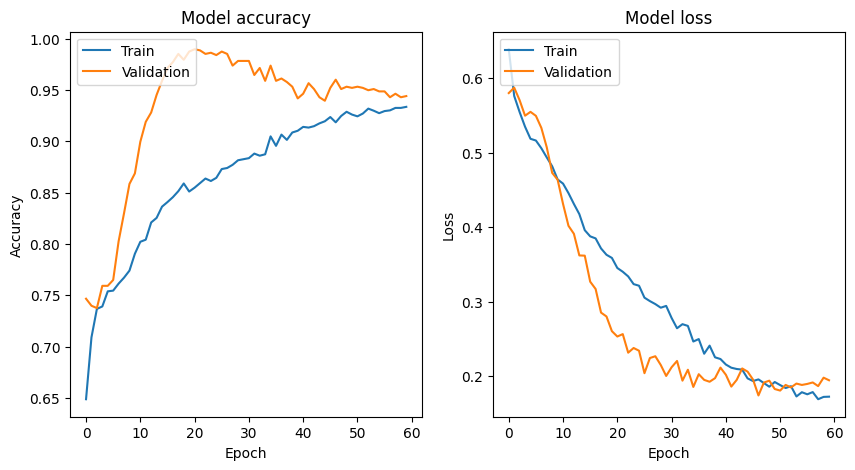

In [11]:
# prompt: generate the code for the training vs validation accuraccy plot

import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history_efficientnetv2.history['accuracy'])
plt.plot(history_efficientnetv2.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_efficientnetv2.history['loss'])
plt.plot(history_efficientnetv2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

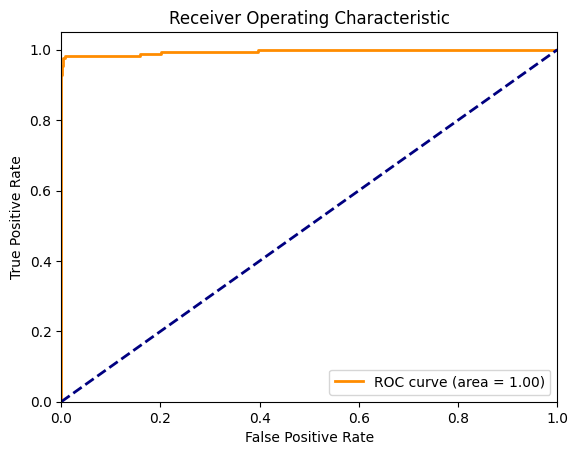

In [8]:
# prompt: make a roc curve of the model

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Assuming y_val contains the true labels and efficientnetv2_preds contains the predicted probabilities
fpr, tpr, thresholds = roc_curve(y_val, efficientnetv2_preds)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

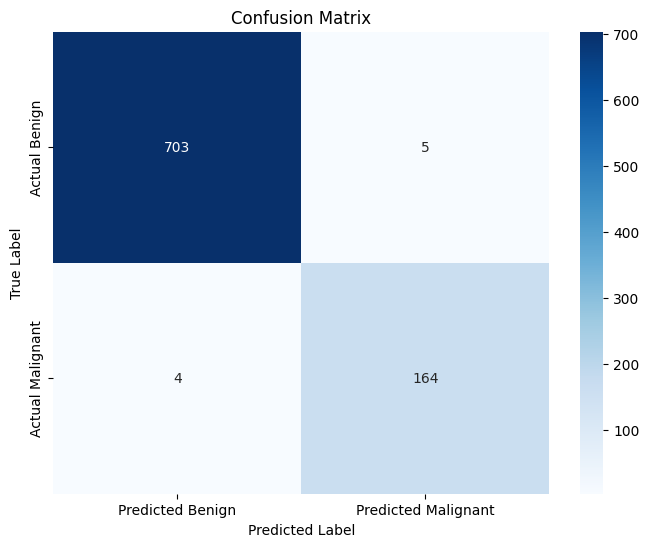

In [9]:
# prompt: make confusion matrix of the model

from sklearn.metrics import confusion_matrix
import seaborn as sns


# Assuming y_val contains the true labels and efficientnetv2_binary_preds contains the predicted classes
cm = confusion_matrix(y_val, efficientnetv2_binary_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Predicted Benign', 'Predicted Malignant'],
            yticklabels=['Actual Benign', 'Actual Malignant'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [10]:
# prompt: make precision of the model

import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import concatenate, Input, Dense, GlobalAveragePooling2D, Conv2D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate, GlobalAveragePooling2D
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.layers import Concatenate
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
import seaborn as sns

# ... (rest of your code)

# Calculate precision, recall, and F1-score
efficientnetv2_precision = precision_score(y_val, efficientnetv2_binary_preds)
efficientnetv2_recall = recall_score(y_val, efficientnetv2_binary_preds)
efficientnetv2_f1 = f1_score(y_val, efficientnetv2_binary_preds)

print(f'EfficientNetV2 Model Precision: {efficientnetv2_precision:.4f}')
print(f'EfficientNetV2 Model Recall: {efficientnetv2_recall:.4f}')
print(f'EfficientNetV2 Model F1-score: {efficientnetv2_f1:.4f}')

EfficientNetV2 Model Precision: 0.9704
EfficientNetV2 Model Recall: 0.9762
EfficientNetV2 Model F1-score: 0.9733
